## 문자 단위 RNN(Char RNN)
- https://wikidocs.net/48649
- RNN은 전부 입력과 출력의 단위가 단어 벡터
- 입출력의 단위를 단어 레벨(word-level)에서 문자 레벨(character-level)로 변경하여 RNN을 구현 가능
- 문자 단위 RNN을 다 대 다(Many-to-Many) 구조로 구현한 경우, 다 대 일(Many-to-One) 구조로 구현한 경우
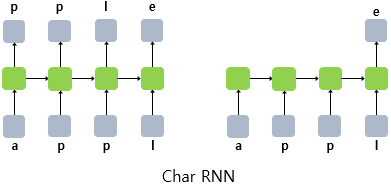

### 문자 단위 RNN 언어 모델(Char RNNLM)
- 단어 단위 RNN 언어 모델과 다른 점은 단어 단위가 아니라 문자 단위를 입, 출력으로 사용
- 임베딩층(embedding layer)을 여기서는 사용 X
- 언어 모델의 훈련 과정과 테스트 과정의 차이를 이해하는데 집중하기~!

#### 데이터에 대한 이해와 전처리
- 특수문자 제거, 단어 소문자화

In [1]:
import numpy as np
import urllib.request
from tensorflow.keras.utils import to_categorical

# 데이터 로드
urllib.request.urlretrieve("http://www.gutenberg.org/files/11/11-0.txt", filename="11-0.txt")

f = open('11-0.txt', 'rb')
sentences = []
for sentence in f: # 데이터로부터 한 줄씩 읽는다.
    sentence = sentence.strip() # strip()을 통해 \r, \n을 제거한다.
    sentence = sentence.lower() # 소문자화.
    sentence = sentence.decode('ascii', 'ignore') # \xe2\x80\x99 등과 같은 바이트 열 제거
    if len(sentence) > 0:
        sentences.append(sentence)
f.close()

In [2]:
sentences[:5]

['the project gutenberg ebook of alices adventures in wonderland, by lewis carroll',
 'this ebook is for the use of anyone anywhere in the united states and',
 'most other parts of the world at no cost and with almost no restrictions',
 'whatsoever. you may copy it, give it away or re-use it under the terms',
 'of the project gutenberg license included with this ebook or online at']

In [7]:
# 하나의 문자열로 통합
# 문자열의 길이는 약 15만 9천
total_data = ' '.join(sentences)
print('문자열의 길이 또는 총 문자의 개수: %d' % len(total_data))

문자열의 길이 또는 총 문자의 개수: 159484


In [8]:
print(total_data[:200])

the project gutenberg ebook of alices adventures in wonderland, by lewis carroll this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with


In [9]:
# 문자열로부터 문자 집합 생성
# 기존에는 중복 제거 단어 집함 생성
# 이번엔 문자집함 생성
char_vocab = sorted(list(set(total_data)))
vocab_size = len(char_vocab)
print ('문자 집합의 크기 : {}'.format(vocab_size))

문자 집합의 크기 : 56


- 문자 집합의 크기는 단어 집합을 사용했을 경우보다 집합의 크기가 현저히 작습니다
    - 알파벳 26개

In [11]:
# 문자 집합의 각 문자에 정수를 부여
char_to_index = dict((char, index) for index, char in enumerate(char_vocab))
print('문자 집합 :',char_to_index)

문자 집합 : {' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, "'": 6, '(': 7, ')': 8, '*': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '?': 26, '[': 27, ']': 28, '_': 29, 'a': 30, 'b': 31, 'c': 32, 'd': 33, 'e': 34, 'f': 35, 'g': 36, 'h': 37, 'i': 38, 'j': 39, 'k': 40, 'l': 41, 'm': 42, 'n': 43, 'o': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 't': 49, 'u': 50, 'v': 51, 'w': 52, 'x': 53, 'y': 54, 'z': 55}


In [12]:
# 정수로부터 문자를 리턴하는 index_to_char 생성
index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

In [14]:
print(index_to_char)

{0: ' ', 1: '!', 2: '"', 3: '#', 4: '$', 5: '%', 6: "'", 7: '(', 8: ')', 9: '*', 10: ',', 11: '-', 12: '.', 13: '/', 14: '0', 15: '1', 16: '2', 17: '3', 18: '4', 19: '5', 20: '6', 21: '7', 22: '8', 23: '9', 24: ':', 25: ';', 26: '?', 27: '[', 28: ']', 29: '_', 30: 'a', 31: 'b', 32: 'c', 33: 'd', 34: 'e', 35: 'f', 36: 'g', 37: 'h', 38: 'i', 39: 'j', 40: 'k', 41: 'l', 42: 'm', 43: 'n', 44: 'o', 45: 'p', 46: 'q', 47: 'r', 48: 's', 49: 't', 50: 'u', 51: 'v', 52: 'w', 53: 'x', 54: 'y', 55: 'z'}


- 훈련 데이터 구성
    - apple라는 시퀀스, 입력 길이 4라고 가정
        - 입력 길이 4 -> 입력 시퀀스, 예츠갷야하는 출력 시퀀스 모두 4
        - RNN 총 4번의 시점을 가질 수 있음
        - apple 은 다섯글자이지만 입력 길이 4이므로 'appl'까지만 입력으로 사용 가능
        - 언어 모델은 다음 시점의 입력을 예측해야하는 모델 -> 'pple'를 예측하도록 데이터가 구성됨

In [15]:
# appl (입력 시퀀스) -> pple (예측해야하는 시퀀스)
train_X = 'appl'
train_y = 'pple'

- 다수 샘플 생성
- 샘플 길이 정하고 -> 문자열 전쳉에 해당 길이만큼 등분

In [16]:
# 문장의 길이 60
seq_length = 60

# 문자열의 길이를 seq_length로 나누면 전처리 후 생겨날 샘플 수
n_samples = int(np.floor((len(total_data) - 1) / seq_length))
print ('샘플의 수 : {}'.format(n_samples))

샘플의 수 : 2658


In [17]:
# 전처리 진행
train_X = []
train_y = []

for i in range(n_samples):
    # 0:60 -> 60:120 -> 120:180로 loop를 돌면서 문장 샘플을 1개씩 pick.
    X_sample = total_data[i * seq_length: (i + 1) * seq_length]

    # 정수 인코딩
    X_encoded = [char_to_index[c] for c in X_sample]
    train_X.append(X_encoded)

    # 오른쪽으로 1칸 쉬프트
    y_sample = total_data[i * seq_length + 1: (i + 1) * seq_length + 1]
    y_encoded = [char_to_index[c] for c in y_sample]
    train_y.append(y_encoded)

- train_y[0]은 train_X[0]에서 오른쪽으로 한 칸 쉬프트 된 문장

In [18]:
print('X 데이터의 첫번째 샘플 :',train_X[0])
print('y 데이터의 첫번째 샘플 :',train_y[0])
print('-'*50)
print('X 데이터의 첫번째 샘플 디코딩 :',[index_to_char[i] for i in train_X[0]])
print('y 데이터의 첫번째 샘플 디코딩 :',[index_to_char[i] for i in train_y[0]])

X 데이터의 첫번째 샘플 : [49, 37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30]
y 데이터의 첫번째 샘플 : [37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30, 43]
--------------------------------------------------
X 데이터의 첫번째 샘플 디코딩 : ['t', 'h', 'e', ' ', 'p', 'r', 'o', 'j', 'e', 'c', 't', ' ', 'g', 'u', 't', 'e', 'n', 'b', 'e', 'r', 'g', ' ', 'e', 'b', 'o', 'o', 'k', ' ', 'o', 'f', ' ', 'a', 'l', 'i', 'c', 'e', 's', ' ', 'a', 'd', 'v', 'e', 'n', 't', 'u', 'r', 'e', 's', ' ', 'i', 'n', ' ', 'w', 'o', 'n', 'd', 'e', 'r', 'l', 'a']
y 데이터의 첫번째 샘플 디코딩 : ['h', 'e', ' ', 'p', 'r', 'o', 'j', 'e', 'c', 't', ' ', 'g', 'u', 't', 'e', 'n', 'b', 'e', 'r', 'g', ' ', 'e',

- train_X와 train_y에 대해서 원-핫 인코딩을 수행
- 문자 단위 RNN에서는 입력 시퀀스에 대해서 워드 임베딩X 
    - 입력 시퀀스에도 원-핫 인코딩 필요

In [20]:
train_X = to_categorical(train_X)
train_y = to_categorical(train_y)

print('train_X의 크기(shape) : {}'.format(train_X.shape)) # 원-핫 인코딩
print('train_y의 크기(shape) : {}'.format(train_y.shape)) # 원-핫 인코딩

train_X의 크기(shape) : (2658, 60, 56)
train_y의 크기(shape) : (2658, 60, 56)


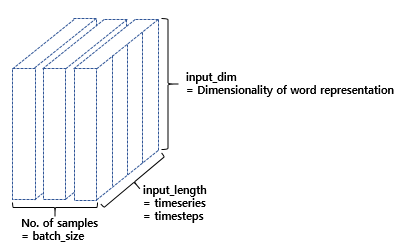

- 샘플 수(No. of samples) : 2658개
- 입력 시퀀스 길이(input_length): 60
- 벡터의 차원(input_dim): 55? 56인듯?

#### 모델 설계하기
- 하이퍼파라미터인 은닉 상태의 크기는 256
- 다 대 다 구조의 LSTM을 사용
- LSTMP 은닉층 2개 사용

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

hidden_units = 256

model = Sequential()
model.add(LSTM(hidden_units, input_shape=(None, train_X.shape[2]), return_sequences=True))
model.add(LSTM(hidden_units, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_y, epochs=80, verbose=2)

Epoch 1/80
84/84 - 23s - loss: 3.0708 - accuracy: 0.1812 - 23s/epoch - 270ms/step
Epoch 2/80
84/84 - 21s - loss: 2.7093 - accuracy: 0.2538 - 21s/epoch - 246ms/step
Epoch 3/80
84/84 - 20s - loss: 2.3588 - accuracy: 0.3379 - 20s/epoch - 243ms/step
Epoch 4/80
84/84 - 20s - loss: 2.2167 - accuracy: 0.3718 - 20s/epoch - 240ms/step
Epoch 5/80
84/84 - 21s - loss: 2.1238 - accuracy: 0.3922 - 21s/epoch - 248ms/step
Epoch 6/80
84/84 - 21s - loss: 2.0338 - accuracy: 0.4165 - 21s/epoch - 249ms/step
Epoch 7/80
84/84 - 20s - loss: 1.9639 - accuracy: 0.4337 - 20s/epoch - 244ms/step
Epoch 8/80
84/84 - 21s - loss: 1.8990 - accuracy: 0.4528 - 21s/epoch - 246ms/step
Epoch 9/80
84/84 - 20s - loss: 1.8417 - accuracy: 0.4679 - 20s/epoch - 243ms/step
Epoch 10/80
84/84 - 20s - loss: 1.7879 - accuracy: 0.4832 - 20s/epoch - 240ms/step
Epoch 11/80
84/84 - 21s - loss: 1.7421 - accuracy: 0.4940 - 21s/epoch - 244ms/step
Epoch 12/80
84/84 - 21s - loss: 1.6998 - accuracy: 0.5050 - 21s/epoch - 247ms/step
Epoch 13/80
8

In [23]:
# 특정 문자를 주면 다음 문자를 계속해서 생성해내는 sentence_generation 함수 생성
def sentence_generation(model, length): #학습한 모델, 다음 문자를 몇 번 생성할 것인지
    # 문자에 대한 랜덤한 정수 생성
    ix = [np.random.randint(vocab_size)]

    # 랜덤한 정수로부터 맵핑되는 문자 생성
    y_char = [index_to_char[ix[-1]]]
    print(ix[-1],'번 문자',y_char[-1],'로 예측을 시작!')

    # (1, length, 55) 크기의 X 생성. 즉, LSTM의 입력 시퀀스 생성
    X = np.zeros((1, length, vocab_size))

    for i in range(length):
        # X[0][i][예측한 문자의 인덱스] = 1, 즉, 예측 문자를 다음 입력 시퀀스에 추가
        X[0][i][ix[-1]] = 1
        print(index_to_char[ix[-1]], end="")
        ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
        y_char.append(index_to_char[ix[-1]])
    return ('').join(y_char)

In [24]:
result = sentence_generation(model, 100)
print(result)

12 번 문자 . 로 예측을 시작!
1/1 [==============================] - 0s 27ms/step
. the rabbit shidd mide a such an fee of them gonsone the best wite speaked it wantther mouse, purzin


### 문자 단위 RNN(Char RNN)으로 텍스트 생성하기
- 다 대 일 구조의 RNN을 문자 단위로 학습

#### 데이터에 대한 이해와 전처리

In [25]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [26]:
# 임의로 만든 엉터리 노래 가사
# 프로그래머이자 맥주라는 단어를 좋아하지만 와인을 갈망한다
raw_text = '''
I get on with life as a programmer,
I like to contemplate beer.
But when I start to daydream,
My mind turns straight to wine.

Do I love wine more than beer?

I like to use words about beer.
But when I stop my talking,
My mind turns straight to wine.

I hate bugs and errors.
But I just think back to wine,
And I'm happy once again.

I like to hang out with programming and deep learning.
But when left alone,
My mind turns straight to wine.
'''

In [27]:
# 단락 구분을 없애고 하나의 문자열로 재저장
tokens = raw_text.split()
raw_text = ' '.join(tokens)
print(raw_text)

I get on with life as a programmer, I like to contemplate beer. But when I start to daydream, My mind turns straight to wine. Do I love wine more than beer? I like to use words about beer. But when I stop my talking, My mind turns straight to wine. I hate bugs and errors. But I just think back to wine, And I'm happy once again. I like to hang out with programming and deep learning. But when left alone, My mind turns straight to wine.


In [28]:
# 중복을 제거한 문자 집합 생성 (모든 알파벳이 들어있지 않고, 대소문자 구분함)
char_vocab = sorted(list(set(raw_text)))
vocab_size = len(char_vocab)
print('문자 집합 :',char_vocab)
print ('문자 집합의 크기 : {}'.format(vocab_size))

문자 집합 : [' ', "'", ',', '.', '?', 'A', 'B', 'D', 'I', 'M', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']
문자 집합의 크기 : 33


In [29]:
char_to_index = dict((char, index) for index, char in enumerate(char_vocab)) # 문자에 고유한 정수 인덱스 부여
print(char_to_index)

{' ': 0, "'": 1, ',': 2, '.': 3, '?': 4, 'A': 5, 'B': 6, 'D': 7, 'I': 8, 'M': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'r': 26, 's': 27, 't': 28, 'u': 29, 'v': 30, 'w': 31, 'y': 32}


In [30]:
# 입력 시퀀스의 길이가 10가 되도록 데이터를 구성
length = 11 #예측 대상 문자 포함
sequences = []
for i in range(length, len(raw_text)):
    seq = raw_text[i-length:i] # 길이 11의 문자열을 지속적으로 만든다.
    sequences.append(seq)
print('총 훈련 샘플의 수: %d' % len(sequences))

총 훈련 샘플의 수: 426


In [31]:
# 10개만 출력
sequences[:10]

['I get on wi',
 ' get on wit',
 'get on with',
 'et on with ',
 't on with l',
 ' on with li',
 'on with lif',
 'n with life',
 ' with life ',
 'with life a']

In [32]:
# 정수 인코딩 수행
encoded_sequences = []
for sequence in sequences: # 전체 데이터에서 문장 샘플을 1개씩 꺼낸다.
    encoded_sequence = [char_to_index[char] for char in sequence] # 문장 샘플에서 각 문자에 대해서 정수 인코딩을 수행.
    encoded_sequences.append(encoded_sequence)

In [33]:
encoded_sequences[:5]

[[8, 0, 16, 14, 28, 0, 24, 23, 0, 31, 18],
 [0, 16, 14, 28, 0, 24, 23, 0, 31, 18, 28],
 [16, 14, 28, 0, 24, 23, 0, 31, 18, 28, 17],
 [14, 28, 0, 24, 23, 0, 31, 18, 28, 17, 0],
 [28, 0, 24, 23, 0, 31, 18, 28, 17, 0, 21]]

In [34]:
# 예측 문자 분리
encoded_sequences = np.array(encoded_sequences)

# 맨 마지막 위치의 문자를 분리
X_data = encoded_sequences[:,:-1]
# 맨 마지막 위치의 문자를 저장
y_data = encoded_sequences[:,-1]

In [35]:
print(X_data[:5])
print(y_data[:5])

[[ 8  0 16 14 28  0 24 23  0 31]
 [ 0 16 14 28  0 24 23  0 31 18]
 [16 14 28  0 24 23  0 31 18 28]
 [14 28  0 24 23  0 31 18 28 17]
 [28  0 24 23  0 31 18 28 17  0]]
[18 28 17  0 21]


In [36]:
# X와 y 원-핫 인코딩 수행
X_data_one_hot = [to_categorical(encoded, num_classes=vocab_size) for encoded in X_data]
X_data_one_hot = np.array(X_data_one_hot)
y_data_one_hot = to_categorical(y_data, num_classes=vocab_size)

In [37]:
print(X_data_one_hot.shape)

(426, 10, 33)


- 샘플 수: 426개
- 입력 시퀀스 길이: 10
- 벡터의 차원: 33

#### 모델 설계하기
- 하이퍼파라미터인 은닉 상태의 크기는 64
- 다 대 일 구조의 LSTM

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

hidden_units = 64

model = Sequential()
model.add(LSTM(hidden_units, input_shape=(X_data_one_hot.shape[1], X_data_one_hot.shape[2])))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_data_one_hot, y_data_one_hot, epochs=100, verbose=2)

Epoch 1/100
14/14 - 2s - loss: 3.4754 - accuracy: 0.0986 - 2s/epoch - 132ms/step
Epoch 2/100
14/14 - 0s - loss: 3.3635 - accuracy: 0.1972 - 43ms/epoch - 3ms/step
Epoch 3/100
14/14 - 0s - loss: 3.1319 - accuracy: 0.1972 - 53ms/epoch - 4ms/step
Epoch 4/100
14/14 - 0s - loss: 3.0115 - accuracy: 0.1972 - 48ms/epoch - 3ms/step
Epoch 5/100
14/14 - 0s - loss: 2.9651 - accuracy: 0.1972 - 45ms/epoch - 3ms/step
Epoch 6/100
14/14 - 0s - loss: 2.9459 - accuracy: 0.1972 - 45ms/epoch - 3ms/step
Epoch 7/100
14/14 - 0s - loss: 2.9274 - accuracy: 0.1972 - 44ms/epoch - 3ms/step
Epoch 8/100
14/14 - 0s - loss: 2.9086 - accuracy: 0.1972 - 45ms/epoch - 3ms/step
Epoch 9/100
14/14 - 0s - loss: 2.8892 - accuracy: 0.1972 - 46ms/epoch - 3ms/step
Epoch 10/100
14/14 - 0s - loss: 2.8596 - accuracy: 0.1972 - 44ms/epoch - 3ms/step
Epoch 11/100
14/14 - 0s - loss: 2.8269 - accuracy: 0.1972 - 45ms/epoch - 3ms/step
Epoch 12/100
14/14 - 0s - loss: 2.7843 - accuracy: 0.2019 - 45ms/epoch - 3ms/step
Epoch 13/100
14/14 - 0s -

In [39]:
# 문장을 생성하는 함수 sentence_generation을 만들어서 문장을 생성
def sentence_generation(model, char_to_index, seq_length, seed_text, n):

    # 초기 시퀀스
    init_text = seed_text
    sentence = ''

    # 다음 문자 예측은 총 n번만 반복.
    for _ in range(n):
        encoded = [char_to_index[char] for char in seed_text] # 현재 시퀀스에 대한 정수 인코딩
        encoded = pad_sequences([encoded], maxlen=seq_length, padding='pre') # 데이터에 대한 패딩
        encoded = to_categorical(encoded, num_classes=len(char_to_index))

        # 입력한 X(현재 시퀀스)에 대해서 y를 예측하고 y(예측한 문자)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for char, index in char_to_index.items():
            if index == result:
                break

        # 현재 시퀀스 + 예측 문자를 현재 시퀀스로 변경
        seed_text = seed_text + char

        # 예측 문자를 문장에 저장
        sentence = sentence + char

    # n번의 다음 문자 예측이 끝나면 최종 완성된 문장을 리턴.
    sentence = init_text + sentence
    return sentence

In [40]:
print(sentence_generation(model, char_to_index, 10, 'I get on w', 80))

I get on with life as a programmer, I like to use words about beer. But when I start to da
